In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tabulate import tabulate
from mpl_toolkits.mplot3d import Axes3D
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import StratifiedKFold, GridSearchCV, RepeatedStratifiedKFold
from sklearn.base import clone
from sklearn import datasets
from sklearn import svm
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from utils import *
from time import time
import os

from IPython.display import display, Latex
from tabulate import tabulate
%load_ext autoreload

%autoreload 2

%matplotlib inline

#change directory to save output here
directory = r"D:\Users\Nick\Desktop\Everything\Uni\Honours Project\Plots\RF_reg/"
plt.rcParams["savefig.directory"] = os.chdir(os.path.dirname(directory))

C:\Users\nickb\AppData\Local\Temp/ipykernel_10264/390674950.py:33: MatplotlibDeprecationWarning: Support for setting an rcParam that expects a str value to a non-str value is deprecated since 3.5 and support will be removed two minor releases later.
  plt.rcParams["savefig.directory"] = os.chdir(os.path.dirname(directory))


In [2]:
RQA_df = pd.read_csv(r"D:\Users\Nick\Desktop\Everything\Uni\Honours Project\rqa_data\RQA_Rossler_y-RQA-Parameters-true_0.02_max_3_2_4_2.csv")

print("- shape is", RQA_df.shape)

display(RQA_df)

- shape is (25100, 15)


,a,DIV,LAM,Vmax,VENTR,Lmax,MRT,NMPRT,RR,RTE,TT,L,ENTR,DET,TREND
0,0.30,0.003891,0.000000,0,NaN,257,44.676294,892,0.020425,1.172377,0.000000,65.800000,2.171571,0.912200,-0.019061
1,0.30,0.003891,0.000000,0,NaN,257,44.777112,888,0.020425,1.178569,0.000000,65.600000,2.079151,0.909427,-0.019769
2,0.30,0.003891,0.000000,0,NaN,257,44.569482,890,0.020425,1.171830,0.000000,65.800000,2.118649,0.912200,-0.020108
3,0.30,0.003891,0.000000,0,NaN,257,44.445172,885,0.020406,1.175427,0.000000,65.466667,1.898927,0.908418,-0.022051
4,0.30,0.003891,0.000000,0,NaN,257,44.602291,885,0.020406,1.178209,0.000000,65.466667,1.898927,0.908418,-0.022051
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25095,0.55,0.029412,0.282002,5,0.447831,34,52.508014,109,0.019613,4.095970,2.154412,6.750000,2.401185,0.805582,0.024333
25096,0.55,0.020408,0.246908,3,0.247725,49,49.614058,169,0.019840,3.567998,2.067729,8.053571,2.595439,0.858230,0.005989
25097,0.55,0.031250,0.246356,6,0.752440,32,46.524205,232,0.019424,3.811100,2.336406,6.391608,2.461300,0.888241,0.001964
25098,0.55,0.016949,0.257737,4,0.731423,59,50.281926,142,0.019519,3.895217,2.348018,6.664062,2.393025,0.824952,-0.016217


In [3]:
RQA_df=RQA_df.fillna(0)

#Rearranging columns into RR -> diagonal -> vertical -> recurrence time features
cols = ["a","RR","DET","L","Lmax","DIV","ENTR","TREND","LAM","TT","Vmax","VENTR","MRT","NMPRT","RTE"]
RQA_df=RQA_df[cols]
feature_set=RQA_df.loc[:, RQA_df.columns != 'a']



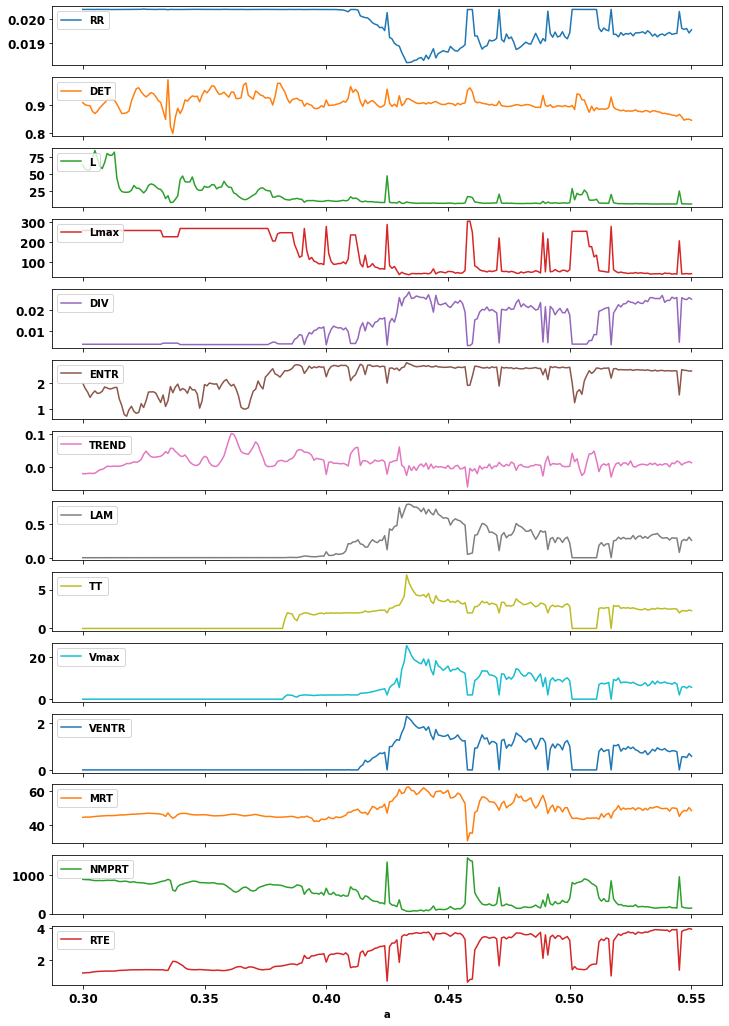

In [4]:
#MRT = Mean Recurrence Time
#NMPRT = Number for Most Probable Recurrence Time
#RTE = Recurrence Time Entropy
RQA_meanvals=RQA_df.groupby(np.arange(len(feature_set))//100).mean()

axes=RQA_meanvals.plot(x="a",subplots=True,figsize=(12,18),fontsize=12)
axes = axes.flat
fig = axes[0].get_figure()
for ax in axes:
    
    ax.legend(loc='upper left')
sns.set_context("notebook", font_scale=1)


plt.show()



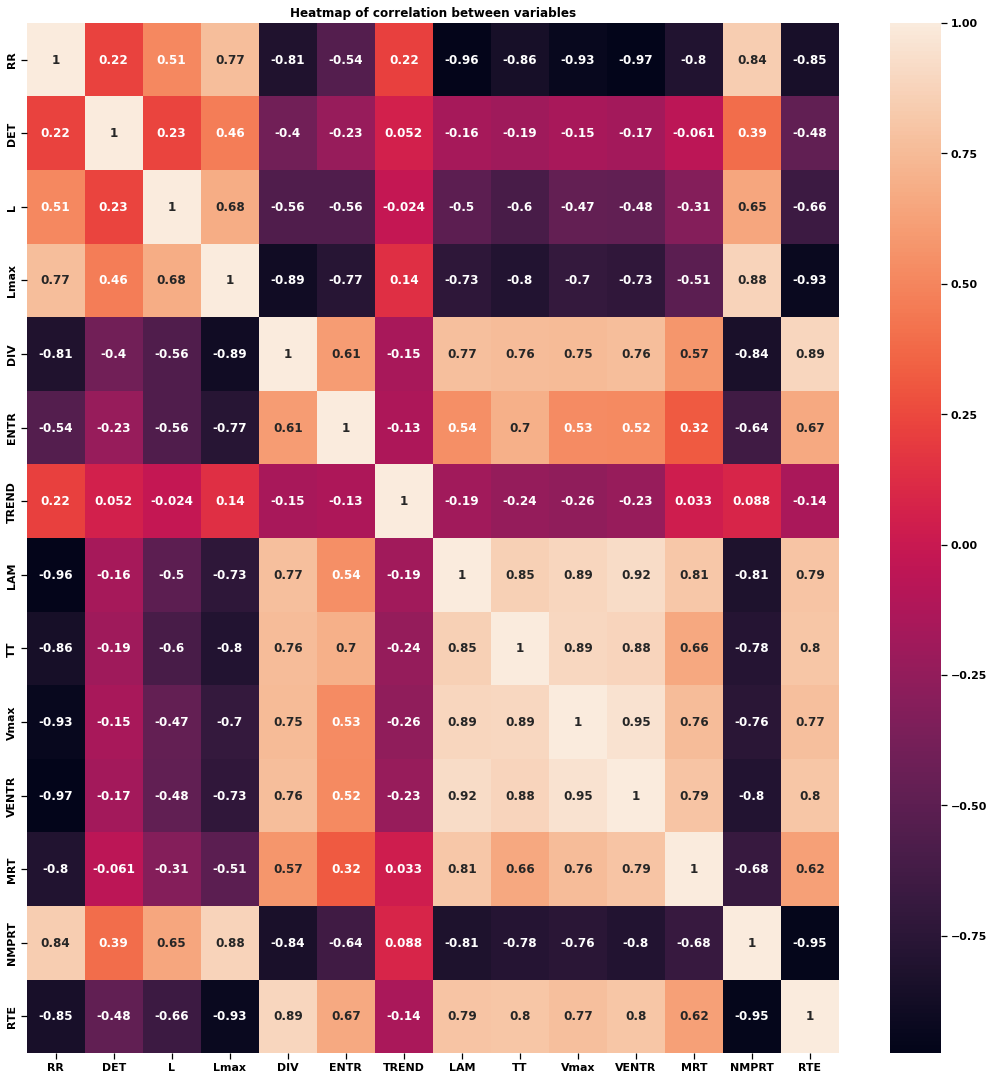

In [5]:
#Pearson Correlation

cm = np.corrcoef(feature_set.values.T)
fig, ax = plt.subplots(figsize=(15,15))
plt.tight_layout()
plt.title("Heatmap of correlation between variables")
sns.heatmap(cm,annot=True,xticklabels=feature_set.columns,yticklabels=feature_set.columns,ax=ax)
plt.show()

In [6]:
#to test with smaller data set and save time change [::"1"] to 5, 10 etc. 1 = WHOLE DATASET
test_set = feature_set.iloc[::1]
target = RQA_df.iloc[::1]["a"]


In [7]:
var_train, var_test,target_train, target_test = train_test_split(test_set,target,test_size=0.3,
                                                                   random_state=0,stratify=target)

In [8]:
tic = time()
l = len(var_train)

#number of tree values from: 
#https://www.semanticscholar.org/paper/How-Many-Trees-in-a-Random-Forest-Oshiro-Perez/dd7863221e722c198dda09bfd3f352c351d1fc6a

max_depthvals = [15,50,75,100]
max_depthvals.append(None)
tree_num =[8,16,32,64,128]


param_grid = {
    'max_features': ["auto","sqrt","log2"],
    'max_depth': max_depthvals,
    'n_estimators': tree_num
}
rf = RandomForestRegressor()
search = GridSearchCV(estimator=rf, param_grid=param_grid,scoring ="r2", refit=False,verbose=2,n_jobs=-1)
search.fit(var_train,target_train)


results_df = pd.DataFrame(search.cv_results_)



elapsed = time()-tic
print("- Elapsed time:")
print("%.4f (s)"%(elapsed))
print("%.4f (min)"%(elapsed/60))
print("%.4f (h)"%(elapsed/(60*60)))




Fitting 5 folds for each of 75 candidates, totalling 375 fits
- Elapsed time:
236.9774 (s)
3.9496 (min)
0.0658 (h)


In [9]:
dd=results_df.sort_values(by=["rank_test_score"])
gridsearch_table=dd[["param_max_depth","param_max_features","param_n_estimators","mean_test_score","rank_test_score"]]

gridsearch_table["param_max_depth"]=gridsearch_table["param_max_depth"].replace(None,"None",regex="None")
gridsearch_table["param_max_depth"]=gridsearch_table["param_max_depth"].fillna('None')
gridsearch_headers = ["Max depth","Max features","Number of trees","Mean test score","Rank"]
print(tabulate(gridsearch_table,headers=gridsearch_headers,tablefmt="latex_raw"))

\begin{tabular}{rllrrr}
\hline
    & Max depth   & Max features   &   Number of trees &   Mean test score &   Rank \\
\hline
 34 & 75.0        & auto           &               128 &          0.972979 &      1 \\
  4 & 15.0        & auto           &               128 &          0.972859 &      2 \\
 49 & 100.0       & auto           &               128 &          0.972758 &      3 \\
 19 & 50.0        & auto           &               128 &          0.972734 &      4 \\
 64 & None        & auto           &               128 &          0.972712 &      5 \\
 59 & 100.0       & log2           &               128 &          0.972653 &      6 \\
 69 & None        & sqrt           &               128 &          0.972592 &      7 \\
 18 & 50.0        & auto           &                64 &          0.972581 &      8 \\
 48 & 100.0       & auto           &                64 &          0.97258  &      9 \\
 39 & 75.0        & sqrt           &               128 &          0.972565 &     10 \\
  3 &

C:\Users\nickb\AppData\Local\Temp/ipykernel_8172/1202621235.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gridsearch_table["param_max_depth"]=gridsearch_table["param_max_depth"].replace(None,"None",regex="None")
C:\Users\nickb\AppData\Local\Temp/ipykernel_8172/1202621235.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gridsearch_table["param_max_depth"]=gridsearch_table["param_max_depth"].fillna('None')


In [10]:
search.best_params_

{'max_depth': 75, 'max_features': 'auto', 'n_estimators': 128}

In [8]:
#bootstrap = False leads to over-fitting

rf = RandomForestRegressor(criterion = "squared_error",n_estimators = 128,max_depth=75,n_jobs=-1,
                           max_features ="auto")
rf=rf.fit(var_train,target_train)


- Elapsed time:
83.3593 (s)
1.3893 (min)
0.0232 (h)


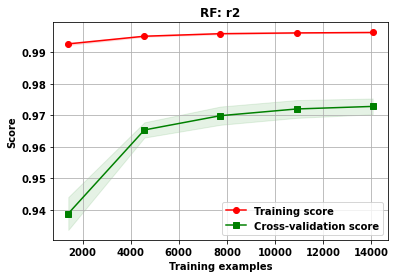

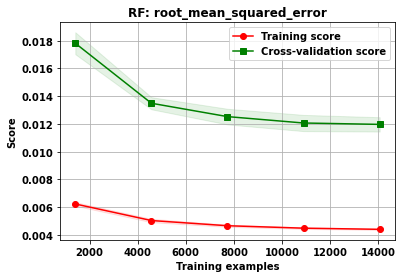

In [13]:
tic = time()
#change scoring here, Scikit convention is that higher scores are better, hence scoring input is the negative errors
#in utils.py, the negative RMSE/absolute error are multiplied by -1 to give their positive values
scoring=["r2","neg_root_mean_squared_error"]

titles = ["r2","root_mean_squared_error"]


i=0
for x in scoring:
    plot_learning_curve_save(rf,title="RF:"+" "+titles[i],X=var_train,y=target_train,
                             n_jobs =-1,scoring=scoring[i],cv=5)
    i+=1

elapsed = time()-tic
print("- Elapsed time:")
print("%.4f (s)"%(elapsed))
print("%.4f (min)"%(elapsed/60))
print("%.4f (h)"%(elapsed/(60*60)))

- Elapsed time:
38.4561 (s)
0.6409 (min)
0.0107 (h)


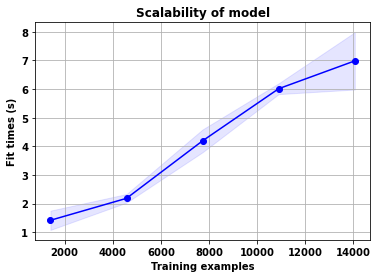

In [14]:
score="r2"
tic=time()

plot_fit_times_curve(rf,title="Scalability of model",X=var_train,y=target_train,
                             n_jobs =-1,scoring=score,cv=5)

elapsed = time()-tic
print("- Elapsed time:")
print("%.4f (s)"%(elapsed))
print("%.4f (min)"%(elapsed/60))
print("%.4f (h)"%(elapsed/(60*60)))

In [9]:
var_train = var_train.sort_index()
target_train = target_train.sort_index()
var_test = var_test.sort_index()
target_test = target_test.sort_index()

In [10]:
#chaos1 = spiral
#chaos2 = screw

rf_predict_train = rf.predict(var_train)
rf_periodic_predict = rf.predict(var_train[:5810])
rf_chaos1_predict = rf.predict(var_train[5810:9240])
rf_chaos2_predict = rf.predict(var_train[9240:])



In [11]:
np.save("RF_TRAIN_PREDICTION",rf_predict_train)
np.save("RF_TRAIN_TARGET",target_train)

In [12]:
#squared = False means RMSE


rmse_periodic = mean_squared_error(target_train[:5810],rf_periodic_predict,squared=False)
rmse_chaos1 = mean_squared_error(target_train[5810:9240],rf_chaos1_predict,squared=False)
rmse_chaos2 = mean_squared_error(target_train[9240:],rf_chaos2_predict,squared=False)

rf_r2 = rf.score(var_train,target_train)
rmse_all = mean_squared_error(target_train,rf_predict_train,squared=False) 



In [13]:
string_r2 = str(np.round(rf_r2,6))
string_rmse = str(np.round(rmse_all,6))

string_periodic = str(np.round(rmse_periodic,6))
string_chaos1 = str(np.round(rmse_chaos1,6))
string_chaos2 = str(np.round(rmse_chaos2,6))

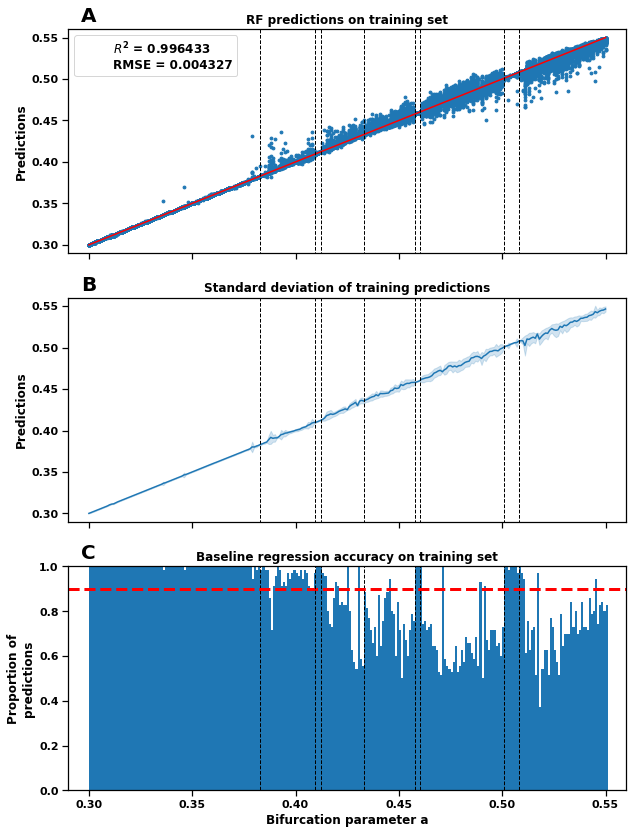

In [14]:
import matplotlib.patches as mpatches

fig, (ax1, ax3,ax2) = plt.subplots(3, 1, figsize=(10, 14),
                               sharex=True)

ax1.text(0.05, 1.1, "A", transform=ax1.transAxes,
      fontsize=20, fontweight='bold', va='top', ha='right')
ax2.text(0.05, 1.1, "C", transform=ax2.transAxes,
      fontsize=20, fontweight='bold', va='top', ha='right')
ax3.text(0.05, 1.1, "B", transform=ax3.transAxes,
      fontsize=20, fontweight='bold', va='top', ha='right')


#Training prediction plot
ax1.scatter(target_train,rf_predict_train,s=8)
ax1.plot(target_train,target_train,color="r")
ax1.set_ylabel("Predictions",fontsize=12)
ax1.set_title("RF predictions on training set",fontsize=12)
ax1.set_ylim([0.29,0.56])
plt.xlim([0.29,0.56])

plt.rcParams["legend.fontsize"] = 12
my_patch = mpatches.Patch(label = " ".join(["$R^2$","=",string_r2]) + "\n"+ " ".join(["RMSE","=",string_rmse])
                          , color="w")
ax1.legend(handles=[my_patch])

ax1.plot([0.43295,0.43295],[0,0.58],"k",linestyle="--",linewidth=1)
ax1.plot([0.383,0.383],[0,0.58],"k",linestyle="--",linewidth=1)

ax1.plot([0.458,0.458],[0,0.58],"k",linestyle="--",linewidth=1)
ax1.plot([0.46,0.46],[0,0.58],"k",linestyle="--",linewidth=1)

ax1.plot([0.501,0.501],[0,0.58],"k",linestyle="--",linewidth=1)
ax1.plot([0.508,0.508],[0,0.58],"k",linestyle="--",linewidth=1)

#Proportion of above baseline prediction plot

trainarray = target_train.to_numpy(copy=True)
trainarray_sort = np.sort(trainarray)

good_vals = []
a_vals = []
for i in range(0,trainarray.size):
    if trainarray[i]-0.01*trainarray[i] <= rf_predict_train[i] <= trainarray[i]+0.01*trainarray[i]:
        good_vals.append(rf_predict_train[i])
        a_vals.append(trainarray[i])


series_a=pd.Series(a_vals)
sorted_series_a=series_a.sort_values()

num = 0
values = sorted_series_a.value_counts(sort=False).keys().tolist()
counts = sorted_series_a.value_counts(sort=False).tolist()
for ii in trainarray_sort[::70]:
    if ii not in values:
        values.insert(num,ii)
        counts.insert(num,0)
    num+=1
    
countarray = np.array(counts)

ax2.bar(values,countarray/70,width=0.001,align='edge')
ax2.set_ylim([0,1])

divcountarray = countarray/70

ax2.plot([0.43295,0.43295],[0,1],"k",linestyle="--",linewidth=1)
ax2.plot([0.383,0.383],[0,1],"k",linestyle="--",linewidth=1)


ax2.plot([0.458,0.458],[0,1],"k",linestyle="--",linewidth=1)
ax2.plot([0.46,0.46],[0,1],"k",linestyle="--",linewidth=1)

ax2.plot([0.501,0.501],[0,1],"k",linestyle="--",linewidth=1)
ax2.plot([0.508,0.508],[0,1],"k",linestyle="--",linewidth=1)


#my_patch = mpatches.Patch(label = " ".join(["$a$ < $a_{spiral}$","=",str(np.round(np.mean(divcountarray[:83]),3))])
                          #+ "\n"+ " ".join(["$a_{spiral}$ < $a$ < $a_{screw}$","=",str(np.round(np.mean(divcountarray[83:132]),3))]) 
                          #+ "\n" + " ".join(["$a > a_{screw}$","=",str(np.round(np.mean(divcountarray[132:]),3))])
                          #, color="w",fill=False)
#box=ax.get_position()
#ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

#plt.legend(handles=[my_patch],loc='center left', bbox_to_anchor=(1, .9))

ax2.set_ylabel("Proportion of"+"\n"+"predictions",fontsize = 12)
ax2.set_title("Baseline regression accuracy on training set",fontsize = 12)
ax2.plot([0.29,0.56],[0.9,0.9],"r",linewidth=3,linestyle="--")

#Standard deviation plot

df_RF_train = pd.DataFrame()
df_RF_train["True"] = target_train
df_RF_train["Predicted"] = rf_predict_train


ci="sd"

ax3.set_title("Standard deviation of training predictions",fontsize=12)
sns.lineplot(x="True", y="Predicted",color="C0", ci=ci, data=df_RF_train, ax=ax3)
ax2.set_xlabel("Bifurcation parameter a",fontsize=12)
ax3.set_ylabel("Predictions",fontsize=12)

ax3.set_xlim([0.29,0.56])
ax3.set_ylim([0.29,0.56])


ax3.plot([0.458,0.458],[0,1],"k",linestyle="--",linewidth=1)
ax3.plot([0.46,0.46],[0,1],"k",linestyle="--",linewidth=1)

ax3.plot([0.501,0.501],[0,1],"k",linestyle="--",linewidth=1)
ax3.plot([0.508,0.508],[0,1],"k",linestyle="--",linewidth=1)


ax3.plot([0.43295,0.43295],[0,1],"k",linestyle="--",linewidth=1)
ax3.plot([0.383,0.383],[0,1],"k",linestyle="--",linewidth=1)

ax1.plot([0.4095,0.4095],[0,1],"k",linestyle="--",linewidth=1)
ax1.plot([0.4125,0.4125],[0,1],"k",linestyle="--",linewidth=1)

ax2.plot([0.4095,0.4095],[0,1],"k",linestyle="--",linewidth=1)
ax2.plot([0.4125,0.4125],[0,1],"k",linestyle="--",linewidth=1)

ax3.plot([0.4095,0.4095],[0,1],"k",linestyle="--",linewidth=1)
ax3.plot([0.4125,0.4125],[0,1],"k",linestyle="--",linewidth=1)


plt.savefig("RF_training_results.pdf",format="pdf",bbox_inches="tight")
plt.show()

In [15]:
rf_predict_test = rf.predict(var_test)
test_rf_periodic_predict = rf.predict(var_test[:2490])
test_rf_chaos1_predict = rf.predict(var_test[2490:3960])
test_rf_chaos2_predict = rf.predict(var_test[3960:])


In [16]:
test_rmse_periodic = mean_squared_error(target_test[:2490],test_rf_periodic_predict,squared=False)
test_rmse_chaos1 = mean_squared_error(target_test[2490:3960],test_rf_chaos1_predict,squared=False)
test_rmse_chaos2 = mean_squared_error(target_test[3960:],test_rf_chaos2_predict,squared=False)

test_rf_r2 = rf.score(var_test,target_test)
test_rmse_all = mean_squared_error(target_test,rf_predict_test,squared=False) 


In [17]:
np.save("RF_TEST_PREDICTION",rf_predict_test)
np.save("RF_TEST_TARGET",target_test)

In [18]:
test_string_r2 = str(np.round(test_rf_r2,6))
test_string_rmse = str(np.round(test_rmse_all,6))

test_string_periodic = str(np.round(test_rmse_periodic,6))
test_string_chaos1 = str(np.round(test_rmse_chaos1,6))
test_string_chaos2 = str(np.round(test_rmse_chaos2,6))

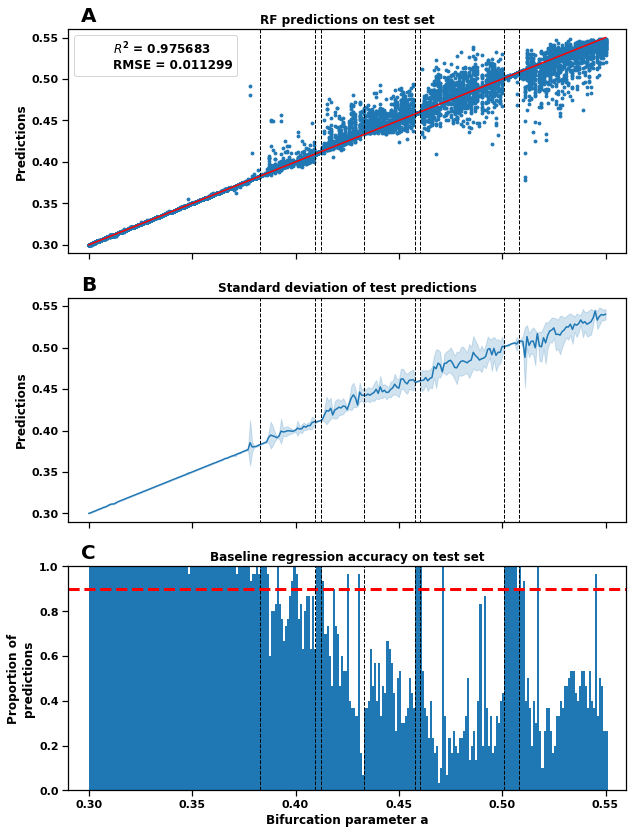

In [19]:


fig,(ax1,ax3,ax2)=plt.subplots(3,1,figsize=(10,14),sharex=True)


ax1.text(0.05, 1.1, "A", transform=ax1.transAxes,
      fontsize=20, fontweight='bold', va='top', ha='right')
ax2.text(0.05, 1.1, "C", transform=ax2.transAxes,
      fontsize=20, fontweight='bold', va='top', ha='right')
ax3.text(0.05, 1.1, "B", transform=ax3.transAxes,
      fontsize=20, fontweight='bold', va='top', ha='right')

#Test Prediction Plot
ax1.scatter(target_test,rf_predict_test,s=8)
ax1.plot(target_test,target_test,color="r")
ax1.set_ylabel("Predictions",fontsize=12)
ax1.set_title("RF predictions on test set",fontsize=12)
ax1.set_xlim([0.29,0.56])
ax1.set_ylim([0.29,0.56])


plt.rcParams["legend.fontsize"] = 12
my_patch2 = mpatches.Patch(label = " ".join(["$R^2$","=",test_string_r2]) + "\n"+ " ".join(["RMSE","=",test_string_rmse])
                          , color="w")
ax1.legend(handles=[my_patch2])

ax1.plot([0.43295,0.43295],[0,0.58],"k",linestyle="--",linewidth=1)
ax1.plot([0.383,0.383],[0,0.58],"k",linestyle="--",linewidth=1)

ax1.plot([0.458,0.458],[0,0.58],"k",linestyle="--",linewidth=1)
ax1.plot([0.46,0.46],[0,0.58],"k",linestyle="--",linewidth=1)

ax1.plot([0.501,0.501],[0,0.58],"k",linestyle="--",linewidth=1)
ax1.plot([0.508,0.508],[0,0.58],"k",linestyle="--",linewidth=1)

#Proportion of above baseline prediction plot

testarray = target_test.to_numpy(copy=True)
testarray_sort = np.sort(testarray)

test_good_vals = []
test_a_vals = []
for i in range(0,testarray.size):
    if testarray[i]-0.01*testarray[i] <= rf_predict_test[i] <= testarray[i]+0.01*testarray[i]:
        test_good_vals.append(rf_predict_test[i])
        test_a_vals.append(testarray[i])


test_series_a=pd.Series(test_a_vals)
test_sorted_series_a=test_series_a.sort_values()

num = 0
test_values = test_sorted_series_a.value_counts(sort=False).keys().tolist()
test_counts = test_sorted_series_a.value_counts(sort=False).tolist()

for ii in testarray_sort[::30]:
    if ii not in values:
        test_values.insert(num,ii)
        test_counts.insert(num,0)
    num+=1
    
test_countarray = np.array(test_counts)

ax2.bar(test_values,test_countarray/30,width=0.001,align='edge')
ax2.set_ylim([0,1])

test_divcountarray =test_countarray/30

ax2.plot([0.43295,0.43295],[0,1],"k",linestyle="--",linewidth=1)
ax2.plot([0.383,0.383],[0,1],"k",linestyle="--",linewidth=1)


ax2.plot([0.458,0.458],[0,1],"k",linestyle="--",linewidth=1)
ax2.plot([0.46,0.46],[0,1],"k",linestyle="--",linewidth=1)

ax2.plot([0.501,0.501],[0,1],"k",linestyle="--",linewidth=1)
ax2.plot([0.508,0.508],[0,1],"k",linestyle="--",linewidth=1)


#my_patch3 = mpatches.Patch(label = " ".join(["$a$ < $a_{spiral}$","=",str(np.round(np.mean(test_divcountarray[:83]),3))])
                          #+ "\n"+ " ".join(["$a_{spiral}$ < $a$ < $a_{screw}$","=",str(np.round(np.mean(test_divcountarray[83:132]),3))]) 
                          #+ "\n" + " ".join(["$a > a_{screw}$","=",str(np.round(np.mean(test_divcountarray[132:]),3))])
                          #, color="w",fill=False)
#box=ax.get_position()
#ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

#plt.legend(handles=[my_patch3],loc='center left', bbox_to_anchor=(1, .9))

ax2.set_ylabel("Proportion of" + "\n"+ "predictions",fontsize = 12)
ax2.set_title("Baseline regression accuracy on test set",fontsize=12)
ax2.plot([0.29,0.56],[0.9,0.9],"r",linewidth=3,linestyle="--")

#Standard deviation plot

df_RF_test = pd.DataFrame()
df_RF_test["True"] = target_test
df_RF_test["Predicted"] = rf_predict_test


ci="sd"

ax3.set_title("Standard deviation of test predictions",fontsize=12)
sns.lineplot(x="True", y="Predicted",color="C0", ci=ci, data=df_RF_test, ax=ax3)
ax2.set_xlabel("Bifurcation parameter a",fontsize=12)
ax3.set_ylabel("Predictions",fontsize=12)
ax3.set_xlim([0.29,0.56])
ax3.set_ylim([0.29,0.56])


ax3.plot([0.43295,0.43295],[0,1],"k",linestyle="--",linewidth=1)
ax3.plot([0.383,0.383],[0,1],"k",linestyle="--",linewidth=1)


ax3.plot([0.458,0.458],[0,1],"k",linestyle="--",linewidth=1)
ax3.plot([0.46,0.46],[0,1],"k",linestyle="--",linewidth=1)

ax3.plot([0.501,0.501],[0,1],"k",linestyle="--",linewidth=1)
ax3.plot([0.508,0.508],[0,1],"k",linestyle="--",linewidth=1)

ax1.plot([0.4095,0.4095],[0,1],"k",linestyle="--",linewidth=1)
ax1.plot([0.4125,0.4125],[0,1],"k",linestyle="--",linewidth=1)

ax2.plot([0.4095,0.4095],[0,1],"k",linestyle="--",linewidth=1)
ax2.plot([0.4125,0.4125],[0,1],"k",linestyle="--",linewidth=1)

ax3.plot([0.4095,0.4095],[0,1],"k",linestyle="--",linewidth=1)
ax3.plot([0.4125,0.4125],[0,1],"k",linestyle="--",linewidth=1)


plt.savefig("RF_test_results.pdf",format="pdf",bbox_inches="tight")
plt.show()

In [20]:
table = [["All a", string_rmse,test_string_rmse],["a < a_{spiral}", string_periodic,test_string_periodic],
         ["a_{spiral} < a < a_{screw}", string_chaos1,test_string_chaos1],
         ["a > a_{screw}", string_chaos2,test_string_chaos2]]
headers = ["Values of a", "RMSE (training set)", "RMSE (test set)"]
print(tabulate(table,headers,tablefmt="latex_raw"))

\begin{tabular}{lrr}
\hline
 Values of a                &   RMSE (training set) &   RMSE (test set) \\
\hline
 All a                      &              0.004327 &          0.011299 \\
 a < a_{spiral}             &              0.000846 &          0.003158 \\
 a_{spiral} < a < a_{screw} &              0.003623 &          0.009427 \\
 a > a_{screw}              &              0.005796 &          0.015024 \\
\hline
\end{tabular}


In [21]:
importances = rf.feature_importances_

data = {"feature_type":["Recurrence rate","Diagonal line features","Diagonal line features","Diagonal line features",
                        "Diagonal line features","Diagonal line features","Diagonal line features",
                        "Vertical line features","Vertical line features","Vertical line features","Vertical line features",
                        "Recurrence time features","Recurrence time features",
                        "Recurrence time features"],
       "Feature":["RR","DET","L","Lmax","DIV","ENTR","TREND","LAM","TT","Vmax","VENTR","MRT","NMPRT","RTE"],
       "Importance value":importances}

df=pd.DataFrame(data)

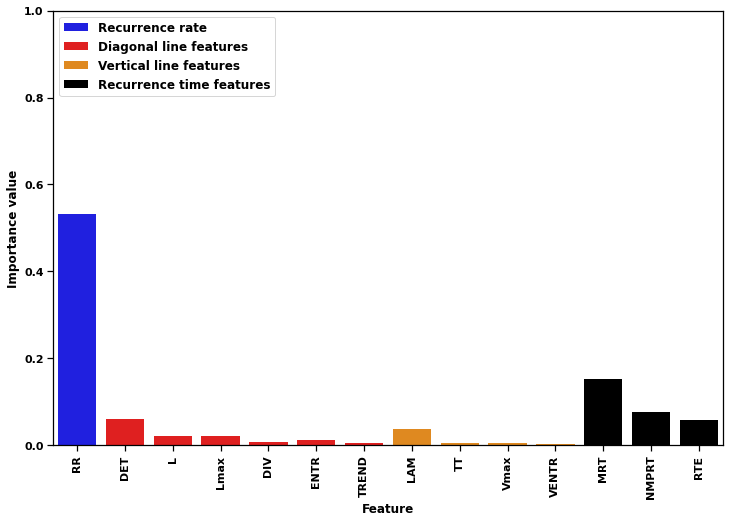

In [22]:
fig,ax = plt.subplots(figsize=(12,8))


ax = sns.barplot(x='Feature', y='Importance value', data=df,palette=["b","r","darkorange","k"], hue='feature_type', dodge=False)
plt.xticks(rotation=90)
plt.ylim([0,1])
plt.legend(loc="upper left")
sns.set_context("notebook", font_scale=2)
plt.savefig("RF_feature_importances.pdf",format="pdf",bbox_inches="tight")
plt.show()

In [23]:
rf_feature_importance_df = pd.DataFrame()
rf_feature_importance_df["Feature"] = feature_set.columns
rf_feature_importance_df["Importance value"] = rf.feature_importances_

table=rf_feature_importance_df.round(6)
headers = ["Feature","Importance value"]
print(tabulate(table,headers=headers,tablefmt="latex_raw"))

\begin{tabular}{rlr}
\hline
    & Feature   &   Importance value \\
\hline
  0 & RR        &           0.532688 \\
  1 & DET       &           0.060619 \\
  2 & L         &           0.021547 \\
  3 & Lmax      &           0.020703 \\
  4 & DIV       &           0.008265 \\
  5 & ENTR      &           0.013288 \\
  6 & TREND     &           0.00444  \\
  7 & LAM       &           0.03759  \\
  8 & TT        &           0.00646  \\
  9 & Vmax      &           0.005265 \\
 10 & VENTR     &           0.002602 \\
 11 & MRT       &           0.15303  \\
 12 & NMPRT     &           0.076104 \\
 13 & RTE       &           0.057397 \\
\hline
\end{tabular}


In [24]:
rf_feature_importance_df = rf_feature_importance_df.round(6)
#diagonal line features
a=rf_feature_importance_df["Importance value"][1:7]
#vertical line features
b=rf_feature_importance_df["Importance value"][7:11]
#recurrence features
c=rf_feature_importance_df["Importance value"][11:]
print("DLF sum",a.sum())
print("VLF sum",b.sum())
print("RTF sum",c.sum())

DLF sum 0.128862
VLF sum 0.051917
RTF sum 0.286531
